In [1]:
import numpy as np
import torch
from torchvision.datasets import mnist
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [2]:
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
train_dataset = mnist.MNIST('./data', train=True, transform = transform, download = True)
test_dataset = mnist.MNIST('./data', train = False, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle = False)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)

C:\temp\ipykernel_15576\4038052834.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


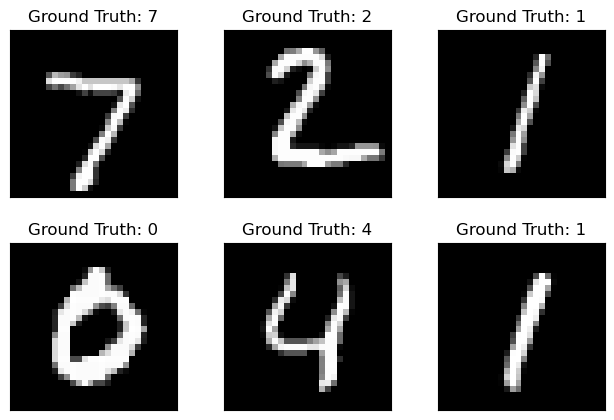

In [5]:
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [6]:
class  Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1,), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(28 * 28, 300, 100, 10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)

In [8]:
losses = []
acces = []
eval_losses = []
eval_acces = []

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    if epoch % 5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
    for img,label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        
        out = model(img)
        loss = criterion(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc


In [9]:
losses.append(train_loss / len(train_loader))
acces.append(train_acc / len(train_loader))
eval_loss = 0
eval_acc = 0
model.eval()

for img, label in test_loader:
    img = img.to(device)
    label = label.to(device)
    img = img.view(img.size(0),-1)
    out = model(img)
    loss = criterion(out, label)
    eval_loss += loss.item()
    _, pred = out.max(1)
    num_correct = (pred == label).sum().item()
    acc = num_correct / img.shape[0]
    eval_acc += acc
eval_losses.append(eval_loss / len(test_loader))
eval_acces.append(eval_acc / len(test_loader))
print('epoch: {}, train_loss: {:.4f}, Train Acc: {: .4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
      .format(epoch, train_loss / len(train_loader), train_acc /len(train_loader), 
             eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 19, train_loss: 0.2098, Train Acc:  0.9482, Test Loss: 0.1861, Test Acc: 0.9544
